In [6]:
import numpy as np
import pandas as pd
import re
import lifelines
from lifelines import KaplanMeierFitter
from sklearn.cluster import KMeans,MiniBatchKMeans,Birch,AgglomerativeClustering,DBSCAN,OPTICS,MeanShift,SpectralClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
from scipy.stats import mannwhitneyu,wilcoxon,shapiro, levene, ttest_ind,f_oneway,kruskal,spearmanr
# import umap
warnings.filterwarnings("ignore")
import os


# Classes and Functions

## Class

In [2]:
class MyDataset():
    def __init__(self,df,df_name=None,metab_num=0):
        self.df_name=df_name
        self.df=df
        self.metab_num=metab_num
    def clean_df(self):
        self.df=self.df.fillna(0)
    def add_cluster_hat(self):
        target_df=pd.DataFrame()
        SEED=16
        sample_number=self.df.shape[0]
        # train model
        cluster_df=self.df.iloc[:,:self.metab_num]
        for n_clusters in range(4,5,1):
            models=[]
            model=KMeans(n_clusters=n_clusters)
            models.append(model)
            model=MiniBatchKMeans(n_clusters=n_clusters)
            models.append(model)
            model=Birch(n_clusters=n_clusters)
            models.append(model)
            model=AgglomerativeClustering(n_clusters=n_clusters)
            models.append(model)
            # model=DBSCAN(min_samples=sample_number//n_clusters)
            # models.append(model)
            # model=OPTICS()
            # models.append(model)
            # model=MeanShift()
            # models.append(model)
            model=SpectralClustering(n_clusters=n_clusters)
            models.append(model)
            # KMeans,MiniBatchKMeans,Birch,DBSCAN,OPTICS,MeanShift,SpectralClustering
            for model in models:
                params={'random_state':SEED}
                if hasattr(model,'random_state'):
                    model.set_params(**params)
                model.fit(cluster_df)
                y_hat=[]
                if hasattr(model,'predict'):
                    y_hat=model.predict(cluster_df)
                else:
                    y_hat=model.fit_predict(cluster_df)
                clusters=np.unique(y_hat)
                cluster_method_name='cluster_'+str(model.__class__.__name__).strip()+'_'+str(n_clusters)
                target_df[cluster_method_name]=y_hat
                target_df.index=self.df.index
        self.clustered_df=target_df.copy(deep=True)        

## Functions

In [3]:
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:  # 判断是否存在文件夹如果不存在则创建为文件夹
        os.makedirs(path)  # makedirs 创建文件时如果路径不存在会创建这个路径
        print ("---  new folder...  ---")
        print ("---  OK  ---")
    else:
        print ("---  There is this folder!  ---")

def display_all():
    pd.set_option('display.max_rows',None)
    pd.set_option('display.max_columns',None)
def display_part():
    pd.set_option('display.max_rows',8)
    pd.set_option('display.max_columns',10)


### Clustering 

In [4]:

def kmeans_clustering(df, n_clusters,metab_num=0):
    """
    :param df: using df
    :param n_clusters: cluster num
    :param metab_num: first n columns to use for clustering
    :return: clustered df 
    """
    df=df.copy(deep=True)
    # Get the feature matrix from the dataframe
    X = df.iloc[:, :metab_num].values
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    # Add the cluster labels to the dataframe
    col_name='k_cluster_'+str(n_clusters)
    df[col_name] = kmeans.labels_
    return df

def nmf_clustering(df, n_components=50,metab_num=0):
    df=df.copy(deep=True)
    # Get the feature matrix from the dataframe
    X = df.iloc[:, :metab_num].values
    # Perform NMF clustering
    nmf = NMF(n_components=n_components)
    W = nmf.fit_transform(X)
    # Add the cluster labels to the dataframe
    col_name='nmf_cluster_'+str(n_components)
    df[col_name] = np.argmax(W, axis=1)
    cluster_names=list(df[col_name].unique())
    cluster_map=dict(zip(cluster_names,list(range(len(cluster_names)))))
    df[col_name] =df[col_name].map(cluster_map)
    return df


def correct_clusters(df, ref_col='m1'):
    
    # Make a copy of the input dataframe
    df = df.copy(deep=True)
    
    # Get the reference cluster labels
    ref_labels = df[ref_col]
    
    # Loop through the other columns
    for col in df.columns:
        print('\n')
        print(col)
        if col != ref_col:
            
            # Get the current labels
            labels = df[col]
            
            # Initialize corrected labels
            corrected = pd.Series(index=labels.index, dtype='object')
            
            # Loop through reference labels
            for tar_label in labels.dropna().unique():
                print(tar_label)
                # Find samples with this reference label
                # ref_samples = ref_labels[ref_labels==ref_label].index
                tar_samples = labels[labels==tar_label].index
                
                # Find best match in current labels
                match_label = ref_labels[tar_samples].value_counts().index[0]

                print(ref_labels[tar_samples].value_counts())
                # tar_samples=labels[labels==match_label].index
                # Update corrected labels
                corrected.loc[tar_samples] = match_label
                
            # Update column with corrected labels
            df[col] = corrected
            
    return df

### Draw

In [5]:

def visualize_tsne(df,ax,label_col='new'):
    # Get the feature matrix from the dataframe

    # Create a scatter plot of the t-SNE embeddings
    types=list(df[label_col].unique())
    # colors=["#green", "blue","orange","red", "#934B43",'#8ECFC9',
    # '#FFBE7A',
    # '#FA7F6F',
    # '#82B0D2',
    # '#BEB8DC',
    # '#E7DAD2']    
    num_unique_categories = df[label_col].nunique()
    colors = sns.color_palette("hls", num_unique_categories)
    color_map=dict(zip(types,colors[:len(types)]))
    sns.scatterplot(ax=ax,data=df,x='tsne_0',y='tsne_1',hue=label_col,palette=colors[:len(types)])
    ax.set_title('TSNE')
    # sns_plt.set(title='TSNE projection of '+label_col)
    # ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df[label_col].map(color_map))
    # ax.set_title('t-SNE Visualization of Sample Distribution')
    # ax.set_xlabel('t-SNE Dimension 1')
    # ax.set_ylabel('t-SNE Dimension 2')
    
    return plt

def draw_umap(df,x,y,label_col,fig_filepath=''):
    labels=df[label_col]
    candidate_colors = ["#8ea3c2", "#8ccdbf", "#edb17f","#f1df82", "#FEA3A2", "#8E8BFE"] 
    plt.figure()
    sns_plt=sns.scatterplot(x,y , hue=labels,palette='Set1')
    sns_plt.set(title='UMAP projection of '+label_col)
    fig=sns_plt.get_figure()
    if fig_filepath!='':
        fig.savefig(filepath)
    else:
        fig.show()
        return fig


### Significant feature

In [6]:
import pandas as pd
from scipy.stats import skew, kurtosis

def bimodality_index(df):

    index = []
    
    for col in df.columns:
        
        series = df[col]
        
        # Calculate skew and kurtosis
        skew_col = skew(series)
        kurtosis_col = kurtosis(series)
        
        # Calculate bimodality coefficient
        b = skew_col**2 + 1 
        bc = (kurtosis_col + 3*(b**2))/(b**2 + 27*(b**2))
        
        # Take negative log10 as index
        index.append(-np.log10(bc))
        
    return index

In [7]:

def get_pvalue_dict(df,label_cols,unwanted_cols=[]):
    
    # delete unwanted
    colnames = df.columns
    colnames = list(set(colnames)-set(label_cols)-set(unwanted_cols))
    classes=list(dict(sorted(dict(df.value_counts(label_cols[0])).items())).keys())
    print(classes)
    pvalue_dict={}
    if(len(classes)>2):
        for i,colname in enumerate(colnames):
            class_features=[]
            df=df.astype({colname:float})
            for label in classes:
                tmp_feature=[]
                # tmp_feature = df.loc[(df[label_cols[0]] == label)]
                tmp_feature = df.loc[(df[label_cols[0]] == label)].loc[:, colname].tolist()
                class_features.append(tmp_feature)

            _, p_value = kruskal(*class_features)
            pvalue_dict[colname]=p_value
    else:
        for i,colname in enumerate(colnames):
            class_features=[]
            df=df.astype({colname:float})
            for label in classes:
                tmp_feature=[]
                # tmp_feature = df.loc[(df[label_cols[0]] == label)]
                tmp_feature = df.loc[(df[label_cols[0]] == label)].loc[:, colname].tolist()
                class_features.append(tmp_feature)

            _, p_value = mannwhitneyu(*class_features)
            pvalue_dict[colname]=p_value
        
    return pvalue_dict


### delete outliners

In [8]:

def get_IQR(x):
    return (np.quantile(x, q=0.75) - np.quantile(x, q=0.25))

def count_outliers(x,iqr_time=1.5):
    outlier_num = len(x[x > (np.quantile(x, q=0.75) + (get_IQR(x)) * iqr_time)])
    return outlier_num

def replace_outliers(x,iqr_time=1.5):
    threshold = (np.quantile(x, q=0.75) + (get_IQR(x)) * iqr_time)
    x[x > threshold] = np.mean(x[x < threshold])
    return x

def delete_outliner(df,metab_num,iqr_time=1.5):
    rawdata_df = df.iloc[:, :metab_num]
    nums = rawdata_df.apply(lambda x : count_outliers(x,iqr_time), axis=0)
    # print(nums)
    fig=plt.figure()
    fig.add_subplot(121)
    plt.hist(nums)
    abnormal_metabolites=[]
    for index,num in enumerate(nums):
        if num>3:
            abnormal_metabolites.append(rawdata_df.columns[index])
    delete_outliner_df=rawdata_df.drop(columns=abnormal_metabolites)
    b = delete_outliner_df.apply(lambda x :replace_outliers(x,iqr_time), axis=0)
    result_df = pd.concat([b, df.iloc[:, metab_num:]], axis=1)
    nums = result_df.iloc[:,:metab_num-len(abnormal_metabolites)].apply(lambda x : count_outliers(x,iqr_time), axis=0)
    # print(nums)
    fig.add_subplot(122)
    plt.hist(nums)
    return result_df


### Normalization

In [9]:
def evaluate_normalization(df_raw, df_normalized,k=''):

    # 计算标准化前后样本spearman相关性
    corr_raw = df_raw.corr(method='spearman')
    corr_normalized = df_normalized.corr(method='spearman')
    
    # 计算相关性矩阵之间的spearmanr
    corr_corr = spearmanr(corr_raw.values.flatten(), corr_normalized.values.flatten())[0]
    if k!='':
        print(f"Sample correlations Spearman r before vs {k}: {corr_corr:.3f}")
    else:    
        print(f"Sample correlations Spearman r before vs after: {corr_corr:.3f}")
    
    return corr_corr


# Operations

In [ ]:
# pd.merge(lipid_df,sample_df,left_index=True,right_index=True)

In [ ]:
kmeans_df=lipid_df.copy(deep=True)
kmeans_df=kmeans_clustering(kmeans_df,3,lipid_num)
kmeans_df=kmeans_df[(kmeans_df['k_cluster_3']==0 )| (kmeans_df['k_cluster_3']==1)]
pvalue_dict=get_pvalue_dict(kmeans_df,lipid_num,['k_cluster_3'])
pvalue_dict

In [ ]:
# kmeans_df.columns[-3:]
lipid_num=lipid_df.shape[1]-1
labels=lipid_df.batch
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(lipid_df.iloc[:,:lipid_num])
x=embedding[:,0]
y=embedding[:,1]
f = plt.figure(figsize=(10,6),dpi=300)
ax=f.add_subplot()
sns_plt=sns.scatterplot(x,y , hue=labels,palette='Set1',ax=ax)
ax.set_title('lipid')
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(lipid_df.iloc[:,:lipid_num])
x=embedding[:,0]
y=embedding[:,1]
kmeans_df=lipid_df.copy(deep=True)
for n_cluster in range(2,5):
    kmeans_df=kmeans_clustering(kmeans_df,n_cluster,lipid_num)
    col_name='k_cluster_'+str(n_cluster)
    fig=draw_umap(kmeans_df,x,y,col_name)
    fig.show()
    plt.figure()
    # filepath='../results/20230902_cluster_lifeline/figs/lipid/'+col_name+'.pdf'
    # fig.savefig(filepath,format='pdf',transparent=True)
    ax = plt.subplot(111)
    for i in range(n_cluster):
        kmf=KaplanMeierFitter()
        tmp_os=sample_df[kmeans_df[col_name]==i]['os']
        tmp_oss=sample_df[kmeans_df[col_name]==i]['oss']
        kmf.fit(tmp_os,tmp_oss,label=i)
        kmf.plot(ax=ax,ci_show=False)
        
    # filepath='../results/20230902_cluster_lifeline/figs/lipid/lifeline_'+str(n_cluster)+'.pdf'
    # plt.savefig(filepath,format='pdf',transparent=True)

## 2023-11-08 Cluster by RNA

### Prepare Data

(111, 49070)
(111, 31789)
(111, 25210)
(111, 18907)
(111, 9453)


(array([2.000e+00, 4.000e+00, 1.800e+01, 1.180e+02, 4.076e+03, 2.446e+03,
        1.721e+03, 8.900e+02, 1.700e+02, 8.000e+00]),
 array([0.65374333, 0.7180181 , 0.78229287, 0.84656764, 0.91084241,
        0.97511719, 1.03939196, 1.10366673, 1.1679415 , 1.23221627,
        1.29649104]),
 <BarContainer object of 10 artists>)

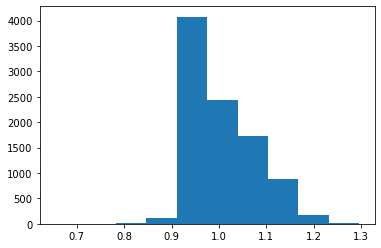

In [188]:
rna_df=pd.read_csv('../data/RNA/ALLsamples_TPM.csv',index_col=0).T
rna_df.index=rna_df.index.str.replace('Ca','')
def replace_index(text):
  pattern = r"T-(\d+)"
  repl = r"\1-T"
  new_text = re.sub(pattern, repl, text)
  return new_text
nmf_df.index=map(replace_index,nmf_df.index)
display_part()
rna_df
# 中间带-，以P结尾
# 中间带有-AS
# 包含超过4个数字
# ['MI', 'AC', 'LINC']开头
# 带有RNU-
# Use list comprehension to quickly filter columns

import re
import pandas as pd
df=rna_df.copy(deep=True)
print(df.shape)
# Patterns to match
p1 = r'.+-P$'  
p2 = r'.+-AS'
p3 = r'\d{4,}'
p4 = r'^(MI|AC|LINC)'
p5 = r'RNU-'

patterns = [p1, p2, p3, p4, p5]

# Compile patterns
regexes = [re.compile(p) for p in patterns]

# Check if column matches any patterns
to_drop = []
for col in df.columns:
  if any(r.search(col) for r in regexes):
    to_drop.append(col)
    
# Drop matching columns
df = df.drop(columns=to_drop)

print(df.shape)

# Threshold for fraction of zeros 
zero_thresh = 2/3

# Calculate fraction of zeros for each column
col_zeros = df.eq(0).mean() 

# Filter columns with more than threshold fraction as zeros
to_drop = col_zeros[col_zeros > zero_thresh].index
df=df.drop(columns=to_drop)
print(df.shape)
df=df.loc[:,df.mean()>np.quantile(df.mean(),0.25)]
print(df.shape)
df=df.loc[:,df.std()>np.quantile(df.std(),0.5)]
print(df.shape)
plt.hist(bimodality_index(df))

In [193]:
batch_1_df=pd.merge(batch_1_df,correct_batch_df.loc[:,['nmf_cluster_4']],left_index=True,right_index=True)

In [195]:
batch_1_df['I_others']=['other' if i!='I' else 'I' for i in batch_1_df.nmf_cluster_4]
batch_1_df['2_others']=['other' if i!='Cluster2' else 'Cluster2' for i in batch_1_df.nmf_cluster_4]


In [206]:
batch_1_df

,SLC7A2,PON1,CROT,ITGAL,YBX2,...,TRBJ1-6,DUS4L-BCAP29,nmf_cluster_4,I_others,2_others
1520,2.263780,1.269589,2.387225,5.354873,0.572079,...,3.959052,1.572725,I,I,other
2139,3.929535,2.135867,2.768765,2.004704,3.224318,...,1.965298,1.357192,A,other,other
2423,0.880715,1.857075,0.936967,0.977655,4.232509,...,0.000000,1.161163,Cluster2,other,Cluster2
2663,0.798894,0.435602,0.818347,3.724129,0.206283,...,2.038513,2.311753,Cluster2,other,Cluster2
...,...,...,...,...,...,...,...,...,...,...,...
8195,1.827321,0.111147,0.362682,3.097209,0.396171,...,0.856549,0.065371,Cluster2,other,Cluster2
8575,0.652879,1.485070,2.914138,1.670859,1.699484,...,1.559720,4.097802,N,other,other
8775,2.863993,4.145823,2.938959,4.161325,3.202880,...,3.406478,3.309238,I,I,other
8339,4.266013,2.136842,2.806362,0.649667,2.061044,...,0.000000,2.231970,N,other,other


In [204]:
I_pvalue_dict=get_pvalue_dict(batch_1_df,['I_others'],['nmf_cluster_4','2_others'])
I_pvalue_df=pd.DataFrame.from_dict(I_pvalue_dict,orient='index',columns=['pvalue'])

Cluster2_pvalue_dict=get_pvalue_dict(batch_1_df,['2_others'],['nmf_cluster_4','I_others'])
Cluster2_pvalue_df=pd.DataFrame.from_dict(Cluster2_pvalue_dict,orient='index',columns=['pvalue'])


['I', 'other']


KeyboardInterrupt: 

In [205]:
# batch_1_df.to_csv('../results/RNA/20231109/rna_batch_1.csv')
# I_pvalue_df.to_csv('../results/RNA/20231109/I_pvalue.csv')
# Cluster2_pvalue_df.to_csv('../results/RNA/20231109/Cluster2_pvalue.csv')

In [183]:
rna_100_df=pd.read_csv('../data/RNA/RNAseq_subtype_xianzhujiyin.csv',index_col=0).T
rna_100_df.index=map(lambda x :x.replace('Ca',''),rna_100_df.index)
rna_100_df=pd.merge(rna_100_df,correct_batch_df.loc[:,['nmf_cluster_4']],left_index=True,right_index=True)
rna_100_df.to_csv('../results/RNA/20231109/rna_100.csv')

In [184]:
nmf_df=nmf_clustering(df,4,df.shape[1])
nmf_1_df=nmf_df.loc[nmf_df.index[[('T' not in tmp_index) for tmp_index in nmf_df.index.tolist()]],:]
nmf_1_df.index=nmf_1_df.index.str.replace('Ca','')
nmf_2_df=nmf_df.loc[nmf_df.index[[('T' in tmp_index) for tmp_index in nmf_df.index.tolist()]],:]
print(nmf_2_df.nmf_cluster_4.value_counts())
# 2_df=nmf_1_df.loc[nmf_1_df.index[[('T' not in tmp_index) for tmp_index in nmf_1_df.index.tolist()]],:]
correct_batch_df=pd.merge(nmf_1_df.loc[:,['nmf_cluster_4']],sample_df.loc[:,['转录组分型']],left_index=True,right_index=True,how='inner')
correct_batch_df=correct_clusters(correct_batch_df,'转录组分型')
correct_batch_df

1    31
0     7
2     6
Name: nmf_cluster_4, dtype: int64


nmf_cluster_4
2
I           10
A            3
Cluster2     3
N            2
Name: 转录组分型, dtype: int64
3
N           14
A            9
Cluster2     8
Name: 转录组分型, dtype: int64
1
N    1
Name: 转录组分型, dtype: int64
0
A    4
Name: 转录组分型, dtype: int64


转录组分型


,nmf_cluster_4,转录组分型
1520,I,I
2139,N,A
2423,N,Cluster2
2663,I,A
2739,I,I
2984,I,I
3243,N,A
4254,N,N
4876,I,I
4931,N,Cluster2


In [114]:
nmf_df.loc[:,['nmf_cluster_4']]=correct_batch_df['nmf_cluster_4']


In [118]:
correction_mapping={1:'I',3:'Cluster2',0:'N',2:'N'}

In [119]:
nmf_df.nmf_cluster_4=[correction_mapping[i] for i in nmf_df.nmf_cluster_4]

In [142]:
len(set(nmf_df.index)&set(sample_df.index))

54

In [134]:
display_all()
display(nmf_df.loc[nmf_df.index[[('T' in tmp_index) for tmp_index in nmf_df.index.tolist()]],:].nmf_cluster_4.value_counts())
display_part()

N           38
I            4
Cluster2     2
Name: nmf_cluster_4, dtype: int64

In [ ]:
sorted(nmf_df.index[[('T' in tmp_index) for tmp_index in nmf_df.index.tolist()]])

In [ ]:
sorted(sample_df.index[[('T' in tmp_index) for tmp_index in sample_df.index.tolist()]])

In [149]:
def replace_index(text):
  pattern = r"T-(\d+)"
  repl = r"\1-T"
  new_text = re.sub(pattern, repl, text)
  return new_text
nmf_df.index=map(replace_index,nmf_df.index)

In [150]:

sample_df=pd.read_csv('../data/SCLC_tissue/第二批/sample_info.csv',index_col=0)
sample_df.set_index('Sample Name', inplace=True)
sample_df=pd.merge(sample_df,nmf_df.loc[:,['nmf_cluster_4']],left_index=True,right_index=True)
sample_df

,hospital_id,batch,os,oss,type,...,次要分型,RNAseq分型,尝试分型,转录组分型,nmf_cluster_4
1520,305980,1,73.100000,0,Y,...,Y,Y,Y,I,I
2423,337236,1,76.633333,0,N,...,NaN,N,A,Cluster2,Cluster2
3334,379551,1,69.400000,0,Y,...,NaN,Y,Y,I,I
1277,297125,1,86.433333,0,P,...,NaN,P,P,Cluster2,Cluster2
...,...,...,...,...,...,...,...,...,...,...,...
200095-T,643779,2,9.312777,0,P,...,NaN,P,P,NaN,Cluster2
200097-T,646890,2,9.486320,0,A,...,NaN,A,A,NaN,N
200128-T,648528,2,20.100000,0,A,...,NaN,A,A,NaN,N
200131-T,649477,2,20.000000,0,A,...,NaN,A,A,NaN,N


In [115]:
pvalue_dict=get_pvalue_dict(nmf_df,['nmf_cluster_4'])

['Cluster2', 'I', 'N']


KeyboardInterrupt: 

In [ ]:
display_part()

In [ ]:
sns.heatmap(df)

In [51]:
rna_df

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,...,AL031178,ELOA3D,XGY2,ELOA3,CDR1
T-120073,5.648570,0.386411,5.319751,4.751367,5.067736,...,0.149639,5.548316,0.000000,5.030023,0.0
T-120155,6.812558,1.367035,5.763529,5.217656,5.787647,...,0.351003,5.788309,0.000000,6.536668,0.0
T-120342,5.441804,0.000000,5.641103,5.219710,5.851142,...,0.042352,6.158814,0.046321,5.576880,0.0
T-120367,5.732847,1.309178,5.302275,5.096098,5.526952,...,0.196391,5.697078,0.000000,5.677330,0.0
...,...,...,...,...,...,...,...,...,...,...,...
Ca8195,0.752031,0.000000,1.738090,1.445745,0.962107,...,0.007882,2.704848,0.000000,1.875792,0.0
Ca8575,4.935406,0.821220,6.158634,4.250603,4.837345,...,0.065471,3.076215,0.000000,2.716556,0.0
Ca8775,3.246432,0.088940,5.097218,3.733199,3.460560,...,0.174611,2.432844,0.000000,2.825637,0.0
Ca8339,3.957804,0.000000,5.582601,5.023400,5.638761,...,0.021468,3.238031,0.000000,3.901858,0.0


In [ ]:
non_code_cols=[]
for col in rna_df.columns:

    for non_code_feature in ['MI','AC','LINC']:
        if non_code_feature in col:
            non_code_cols.append(col)
display_all()
display(rna_df.drop(columns=non_code_cols))
display_part()

In [34]:
rna_mean=rna_df.mean()
rna_std=rna_df.std()
rna_coef=rna_std/rna_mean

In [44]:
rna_mean

TSPAN6      3.606458
TNMD        0.465031
DPM1        4.714147
SCYL3       3.737126
              ...   
AC093246    0.022837
AC005192    0.405081
CDR1        0.022740
AC084756    0.547809
Length: 49070, dtype: float64

In [45]:
rna_std

TSPAN6      1.639681
TNMD        0.532782
DPM1        1.297041
SCYL3       1.233072
              ...   
AC093246    0.059964
AC005192    0.819601
CDR1        0.115134
AC084756    0.531797
Length: 49070, dtype: float64

In [46]:
rna_coef[rna_coef>0.3].sort_values()

CCNB1IP1      0.300013
SDHD          0.300015
DHX32         0.300020
ATP8B1        0.300044
               ...    
RN7SL654P    10.535654
SNRPGP7      10.535654
AL356754     10.535654
AL356157     10.535654
Length: 41828, dtype: float64

### Prepare Data

In [ ]:
rna_df.index=rna_df.index.str.replace('Ca','')
batch_1_rna_df=rna_df.loc[rna_df.index[[('T' not in tmp_index) for tmp_index in rna_df.index.tolist()]],:]
batch_1_rna_df
batch_2_rna_df=rna_df.loc[rna_df.index[[('T' in tmp_index) for tmp_index in rna_df.index.tolist()]],:]
print(batch_1_rna_df.columns[-5:])
metab_num=rna_df.shape[1]
print(rna_df.shape)
sample_df=pd.read_csv('../data/SCLC_tissue/第二批/sample_info.csv',index_col=0)
sample_df.set_index('Sample Name', inplace=True)

In [25]:
batch_1_rna_df.shape

(67, 49070)

In [30]:
sample_df[~sample_df.index.str.contains('T')].shape

(57, 11)

In [24]:
sample_df.转录组分型

Sample Name
1520               I
2423        Cluster2
3334               I
1277        Cluster2
4931        Cluster2
6137               A
2039               A
2236        Cluster2
2257               A
2663               A
2877               N
3243               A
4254               N
1452               N
1775               N
1272             NaN
1870        Cluster2
2707               A
2706               A
8195        Cluster2
2139               A
4059               N
5058               A
2667               I
2739               I
4202               N
5608               A
5759               N
6625               A
6927               N
7311               N
7970        Cluster2
7991               N
8024        Cluster2
8232               I
8339               N
8775               I
8816               N
1334             NaN
2026               A
2480        Cluster2
2669               A
4876               I
5078               A
6808               A
6864               N
8105               N
8

In [137]:
batch_1_rna_df=kmeans_clustering(batch_1_rna_df,4,metab_num)
print(batch_1_rna_df.columns[-5:])


Index(['AC093246', 'AC005192', 'CDR1', 'AC084756', 'k_cluster_4'], dtype='object')


In [138]:
correct_batch_df=pd.merge(batch_1_rna_df.loc[:,['k_cluster_4']],sample_df.loc[:,['转录组分型']],left_index=True,right_index=True,how='left')

### Different Clustering Methods

In [ ]:
batch_1_rna_dataset=MyDataset(batch_1_rna_df,'rna_1',metab_num)
batch_1_rna_dataset.add_cluster_hat()
correct_batch_df=pd.merge(batch_1_rna_dataset.clustered_df,sample_df.loc[:,['转录组分型']],left_index=True,right_index=True,how='left')
correct_batch_df
display_all()


In [ ]:
correct_cluster_result_df=correct_clusters(correct_batch_df,'转录组分型')

In [ ]:
correct_cluster_result_df

In [ ]:
df = correct_cluster_result_df.copy(deep=True)
ref_col='转录组分型'

ref_labels=['A','I','N','Cluster2']

for col in df.columns:
    if col != ref_col:
        for ref_label in ref_labels:
            
        

In [ ]:
col='转录组分型'
labels=correct_batch_df[col]
labels.value_counts()

In [ ]:

    # Make a copy of the input dataframe
    df = correct_batch_df.copy(deep=True)
    ref_col='转录组分型'
    # Get the reference cluster labels
    ref_labels = df[ref_col]
    # Loop through the other columns
    for col in df.columns:
        if col != ref_col:
            
            # Get the current labels
            labels = df[col]
            print(labels)

            # Initialize corrected labels
            corrected = pd.Series(index=labels.index, dtype='object')
            
            # Loop through reference labels
            for ref_label in ref_labels.dropna().unique():
                print(ref_label)

                # Find samples with this reference label
                ref_samples = ref_labels[ref_labels==ref_label].index
                print(ref_samples)
                # Find best match in current labels
                match_label = labels[ref_samples].value_counts().index[0]
                match_samples=labels[labels==match_label].index
                # Update corrected labels
                corrected.loc[ref_samples] = ref_label
                
            # Update column with corrected labels
            df[col] = corrected

#### NMF

In [21]:
display_all()
nmf_df=nmf_clustering(batch_1_rna_df,4,metab_num)
correct_batch_df=pd.merge(nmf_df.loc[:,['nmf_cluster_4']],sample_df.loc[:,['转录组分型']],left_index=True,right_index=True,how='left')
correct_batch_df=correct_clusters(correct_batch_df,'转录组分型')




nmf_cluster_4
0
I    10
N     3
A     1
Name: 转录组分型, dtype: int64
1
A    11
N     6
Name: 转录组分型, dtype: int64
2
Cluster2    11
A            4
N            2
Name: 转录组分型, dtype: int64
3
N    6
Name: 转录组分型, dtype: int64


转录组分型


In [31]:
correct_batch_df[correct_batch_df['nmf_cluster_4']!=correct_batch_df['转录组分型']].sort_values(by='nmf_cluster_4').dropna()

,nmf_cluster_4,转录组分型
6927,A,N
1452,A,N
8855,A,N
2877,A,N
4059,A,N
8105,A,N
5608,Cluster2,A
5058,Cluster2,A
6808,Cluster2,A
2257,Cluster2,A


## 2023-11-15 NMF Clustering

In [10]:
metab_filepath='D:/repositories/liver-cancer/tasks/Tissue/data/20231009_batch_sum/metab.csv'
metab_df=pd.read_csv(metab_filepath,index_col=0)
metab_num=metab_df.shape[1]-1
# for index in metab_df.index:
#     print(index)
sample_df=pd.read_csv('../data/SCLC_tissue/第二批/sample_info.csv')
sample_df.set_index('Sample Name',inplace=True)
# # 2707 and 173161 is deleted in this file
metab_df.drop(index='2707',inplace=True)
sample_df.drop(index='2707',inplace=True)
sample_df.shape
# metab_df=metab_df.loc[list(set(metab_d\f.index)&set(sample_df.index)),:]
metab_df=metab_df.drop(index='173161-2-T')
metab_df=metab_df.rename(index={'173161-1-T':'173161-T'})
sample_df=sample_df.loc[list(set(metab_df.index)&set(sample_df.index)),:]
# # Raw
# raw_metab_df=metab_df.iloc[:,:metab_num]
# raw_metab_df+=abs(raw_metab_df.min().min())+1
# metab_df=pd.concat([raw_metab_df,metab_df.iloc[:,metab_num:]],axis=1)
metab_df.shape
# Delete Abnormal Samples
abnormal_sample_indexes=['210012-T','8195','2236']
metab_df.drop(index=abnormal_sample_indexes,inplace=True)
sample_df.drop(index=abnormal_sample_indexes,inplace=True)
metab_df.shape
# metab_df
# metab_df=pd.merge(metab_df,sample_df.loc[:,['type']],left_index=True,right_index=True)
# metab_df.to_csv('../results/20231010/csvs/metab_type.csv')
metab_num=metab_df.shape[1]-1

### Data Normalization

In [ ]:
metab_df=apply_combat(metab_df,metab_num)

## 2023-11-29
- Try to fit negative